# Dynamic Energy Budget

The previous calculations only concern the final stable state where energy influx equals the outgoing radiation energy once equilibrium temperature is reached. But this does not take into account that global warming happens over time.

In [167]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
from collections import namedtuple

%matplotlib inline

## Bare Earth Model

In order to introdce the time factor, we compute net energy flux over some timestep and adjust the earth' heat budget accordingly.

In [168]:
# physical constants
SOLAR_CONSTANT = 1350 #[W/m^2]
EPSILON = 1
SIGMA = 5.67 * 10**-8 #[W/m^2/K^4]

# Seconds equivalents
DAY = 60 * 60 * 24
YEAR = DAY * 365

First, however, we need to make some assumptions about geography. For simplicity, we assume a planet that is fully covered with water of a certain depth:

In [169]:
ocean_depth = 4000 #[m]

1 calorie is the amount of energy needed to heat 1 gram of water by 1 degree, and 4.18 Joule are about the equivalent of 1 calorie. This allows us to determine the energy stored in our model ocean:

In [170]:
def heat_capacity(ocean_depth):
    """return the amount of energy required to heat up a 1m^2 * depth cube of water"""
    return ocean_depth * 4.18 * 1E6

From here, we can find the total heat content of the earth. For instance, at a temperature of $0°C$, or $272.15 K$, this would be:

In [171]:
# example heat content
272.15 * heat_capacity(ocean_depth) #[J/m^2]

4550348000000.0

Conversely, from the heat content, we can find the surface temperature:

In [172]:
def temperature(heat_content, ocean_depth):
    """Return the earth surface temperature"""
    return heat_content / heat_capacity(ocean_depth)

The model will now compute the energy influx from the sun over one timestep, adjust the heat content, and then determine the new temperature. With a new temperature, we can compute a new output radiation in the next timestep.

In [173]:
def energy_in(albedo, dist=1):
    """Return influx from the sun"""
    return SOLAR_CONSTANT / dist**2 * (1 - albedo) / 4

In [174]:
def energy_out(temperature):
    """Return outflux from earth's radiation"""
    return EPSILON * SIGMA * temperature**4

With this in place, we can determine the total change in the earth's energy budget:

In [175]:
def net_heat_flux(duration, heat_content, ocean_depth, albedo, dist):
    """Return total heat absorbed or emitted"""
    return (energy_in(albedo, dist) - energy_out(temperature(heat_content, ocean_depth))) * duration

This formula requires a duration to be set: with a longer duration, more energy can flow. This also implies that **the model will be more accurate when smaller timesteps are chosen.**

Let's run a simulation over some 1-year long timesteps, starting from an initial temperature of $0K$. We also reuse some assumptions from the previous model:

In [176]:
def run_simulation():
    """Return temperatures for each epoch of the simulation"""
    # model assumptions
    albedo = 0.3
    dist = 1 #[AU]
    temperature_init = 0

    # simulation parameters
    timestep = YEAR
    epochs = 1500

    # collect temperature development over time
    temperatures = []

    # initial heat content
    heat_content = heat_capacity(ocean_depth) * temperature_init

    for _ in range(epochs):
        heat_content += net_heat_flux(timestep, heat_content, ocean_depth, albedo, dist)
        temperatures.append(temperature(heat_content, ocean_depth))
        
    return temperatures

In [177]:
temperatures = run_simulation()

We can now see how temperatures would develop over 1500 years. Let's convert to Celsius before plotting.

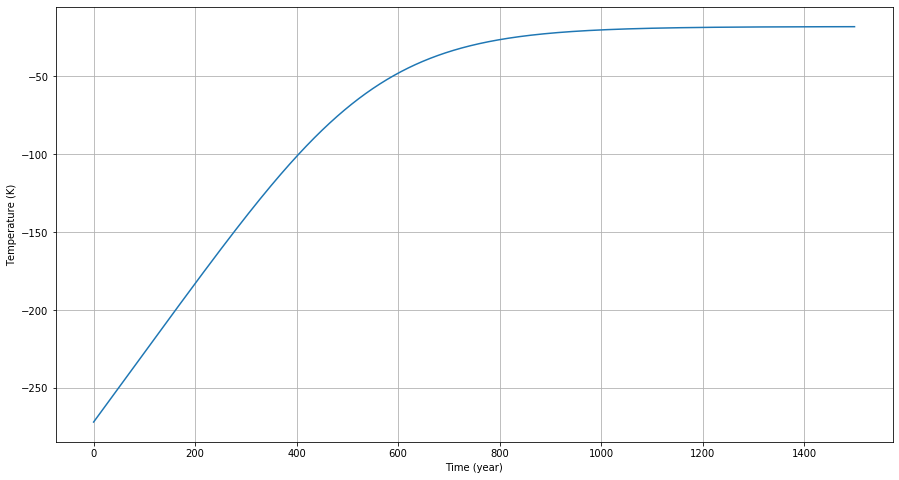

In [178]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Time (year)')
sns.lineplot(range(len(temperatures)), [t - 272.15 for t in temperatures]);

The model will converge to the same stable state as the analytical solution, after about 1000 years:

In [179]:
# Final state in Kelvin and Celsius
temperatures[-1], temperatures[-1] - 272.15

(254.00220395376684, -18.14779604623314)

As with the static model, this bare earth model converges to too low a termperature because we did not account for any atmosphere.

## Introducting an Atmosphere

The main additional factor that needs to be considered is the energy that the warm atmosphere radiates back to earth. Modeling the atmosphere as a pane, and assuming it reacts immediately to the infrared radiation coming from earth, all we need to do is add the respective term the the suface energy budget.

But before we go there, let's refactor the above code a bit to make it more reusable. In particular, let's introduce an parameter container that can configure the different parts of the simulation.

In [180]:
Parameters = namedtuple(
    'Parameters',
    'albedo distance ocean_depth initial_temperature timestep epochs')
Parameters.__new__.__defaults__ = (0.3, 1, 4000, 0, 1, 1)

In [181]:
def run_simulation(energy_in, energy_out, params):
    """Return temperatures for each epoch of the simulation"""
    temperatures = []
    heat_content = heat_capacity(params.ocean_depth) * params.initial_temperature

    for _ in range(params.epochs):
        t_ground = temperature(heat_content, params.ocean_depth)
        e_in = energy_in(t_ground, params)
        e_out = energy_out(t_ground)
        heat_content += (e_in - e_out) * params.timestep
        temperatures.append(t_ground)
        
    return temperatures

We can now write our new `energy_in` function that also accounts for reflected energy:

In [182]:
def energy_in_with_reflection(t_ground, params):
    """Return influx from the sun plus atmosphere reflection"""
    solar_in = SOLAR_CONSTANT / params.distance**2 * (1 - params.albedo) / 4
    atmospheric_reflection = 1/2 * EPSILON * SIGMA * t_ground**4
    return solar_in + atmospheric_reflection

That suffice to run the adapted simulation with default parameters, once again over 1500 years:

In [183]:
params = Parameters(timestep=YEAR, epochs=1500)
temperatures = run_simulation(energy_in_with_reflection, energy_out, params)

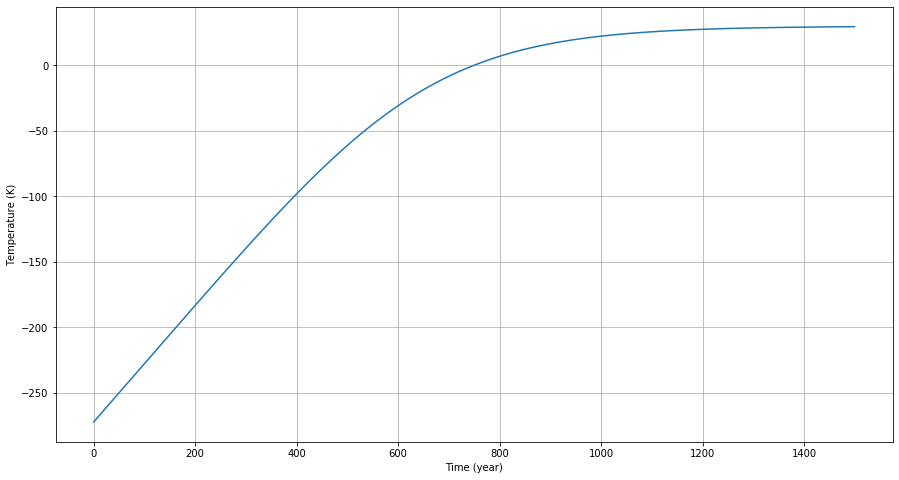

In [184]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Time (year)')
sns.lineplot(range(len(temperatures)), [t - 272.15 for t in temperatures]);

In [185]:
# Final state in Kelvin and Celsius
temperatures[-1], temperatures[-1] - 272.15

(301.72507152067817, 29.575071520678193)

We have arrived at the same stationary temperature as with the static model. But now we can estimate on which timescale changes take place.

What if a series of massive Volcano eruptions were to darken the sky and reduce the incoming light from the sun by, say, 20%? How long would it take for the temperature to adjust? And where will it reach a new equilibrium? Less incoming energy can be expressed though a higher albedo. We'll pick 0.45 which comes close to a 20% reduction. And we use the most recent temperature value as starting value for the next round of simulation:

In [186]:
params = Parameters(
    albedo=0.45,
    initial_temperature=302,
    timestep=YEAR,
    epochs=1500)

temperatures = run_simulation(energy_in_with_reflection, energy_out, params)

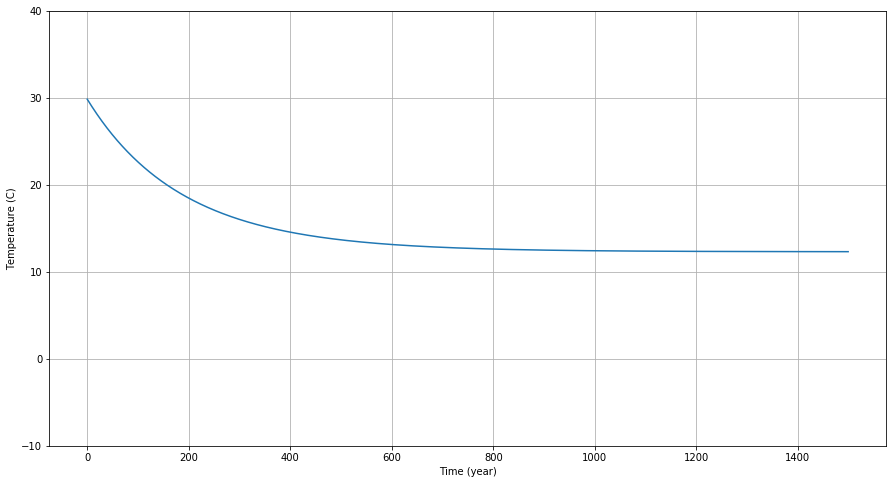

In [187]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_ylim((-10, 40))
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Time (year)')
sns.lineplot(range(len(temperatures)), [t - 272.15 for t in temperatures]);

It looks like after about 800 years earth would reach a new stable state at a lower temperature of:

In [189]:
# new equilibrium temperature in Kelvin and Celsius
temperatures[-1], temperatures[-1] - 272.15

(284.4695796426107, 12.319579642610734)